In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt  # Used for data visualization (plots)
import numpy as np               # Used for numerical operations (arrays, range, etc.)
import pandas as pd              # Used for data manipulation (DataFrame, Series, etc.)
import seaborn as sns            # Used for advanced plotting and better visuals
from IPython.display import display  # Used to display objects (in Jupyter Notebooks)
from sklearn.feature_selection import mutual_info_regression  # For calculating mutual information


# Configure layout settings for all plots to make them automatically adjust for better presentation
plt.rc("figure", autolayout=True)

# Set specific configurations for axes in all plots
plt.rc(
    "axes",
    labelweight="bold",  # Make axis labels bold
    labelsize="large",   # Set axis label size to large
    titleweight="bold",  # Make plot titles bold
    titlesize=14,        # Set plot title size to 14
    titlepad=10,         # Add padding to the title
)

# Define a function to plot the explained and cumulative variance from PCA results
def plot_variance(pca, width=8, dpi=100):
    """
    This function takes the PCA (Principal Component Analysis) object
    and plots two things:
    1. Explained variance for each principal component.
    2. Cumulative variance across all components.

    Parameters:
    - pca: A fitted PCA object from sklearn.
    - width: The width of the figure in inches (default is 8).
    - dpi: Dots per inch for the figure resolution (default is 100).

    Returns:
    - axs: The axes for the subplots containing the variance plots.
    """

    # Create a subplot with two axes (side by side)
    fig, axs = plt.subplots(1, 2)

    # Get the number of principal components
    n = pca.n_components_

    # Create a grid of numbers from 1 to n (number of components)
    grid = np.arange(1, n + 1)

    # Get the explained variance ratio for each component
    evr = pca.explained_variance_ratio_

    # Plot the explained variance for each component as a bar chart
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component",  # Label for x-axis
        title="% Explained Variance",  # Title for the plot
        ylim=(0.0, 1.0)  # Limit the y-axis to a range between 0 and 1
    )

    # Calculate cumulative variance by summing up the explained variance
    cv = np.cumsum(evr)

    # Plot the cumulative explained variance
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")  # "o-" creates a line with dots at data points
    axs[1].set(
        xlabel="Component",  # Label for x-axis
        title="% Cumulative Variance",  # Title for the plot
        ylim=(0.0, 1.0)  # Limit the y-axis to a range between 0 and 1
    )

    # Adjust the figure settings (width and resolution)
    fig.set(figwidth=8, dpi=100)

    # Return the axes to allow further customization if needed
    return axs

# Define a function to calculate and return mutual information (MI) scores between features and target
def make_mi_scores(X, y, discrete_features):
    """
    This function calculates the mutual information (MI) scores for each feature
    with respect to the target variable using the mutual_info_regression method from sklearn.

    Parameters:
    - X: The feature matrix (DataFrame or 2D array).
    - y: The target variable (array or Series).
    - discrete_features: A list or array indicating which features are discrete (categorical).

    Returns:
    - mi_scores: A sorted pandas Series with mutual information scores for each feature.
    """

    # Calculate mutual information scores between the features (X) and target (y)
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)

    # Convert the scores into a pandas Series with feature names as index
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    # Sort the MI scores in descending order (features with higher MI scores are more informative)
    mi_scores = mi_scores.sort_values(ascending=False)

    # Return the sorted MI scores
    return mi_scores


In [5]:
#Import Data From CSV File
df = pd.read_csv("/content/autos.csv")

In [6]:
# Define a list of features (columns) you want to use as input variables
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

# Create a copy of the original DataFrame to preserve the original data
X = df.copy()

# Separate the target variable ('price') from the feature variables
y = X.pop('price')

# Select the specific features (columns) for the model from the DataFrame
X = X.loc[:, features]

# Standardize the feature variables (X)
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)


In [7]:
# Import PCA (Principal Component Analysis) from sklearn
from sklearn.decomposition import PCA

# Initialize PCA with default parameters
pca = PCA()

# Fit the PCA model to the standardized features and transform the data into principal components
X_pca = pca.fit_transform(X_scaled)

# Generate the component names as "PC1", "PC2", ..., based on the number of components
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

# Create a DataFrame with the transformed data and assign the component names as column names
X_pca = pd.DataFrame(X_pca, columns=component_names)

# Display the first few rows of the transformed data
X_pca.head()


,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [8]:
# Create a DataFrame for the PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose the PCA components (from shape [n_components, n_features] to [n_features, n_components])
    columns=component_names,  # Assign column names corresponding to the principal components (PC1, PC2, etc.)
    index=X.columns,  # Assign row names corresponding to the original features in X
)

# Display the loadings DataFrame
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


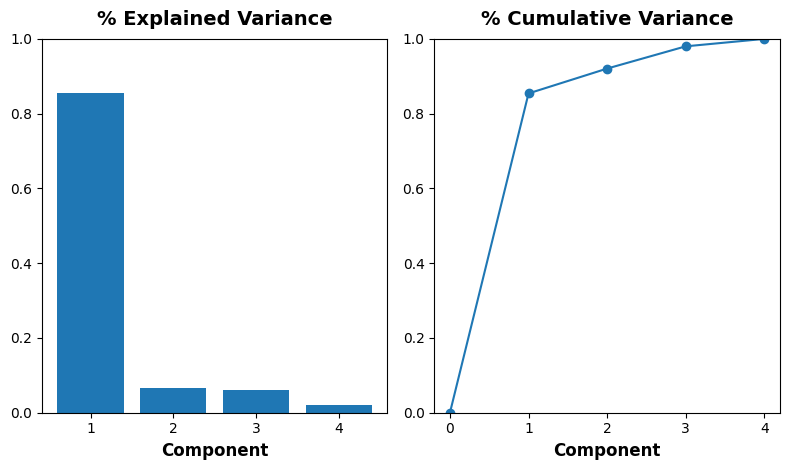

In [9]:
# Look at explained variance
plot_variance(pca);

In [10]:
# Calculate Mutual Information (MI) scores for the principal components (X_pca) with respect to the target variable (y)
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)

# Display the MI scores
mi_scores

,MI Scores
PC1,1.014582
PC2,0.379156
PC3,0.306072
PC4,0.203329


In [11]:
# Sort the values of the "PC3" principal component in descending order and get the index of the sorted values
idx = X_pca["PC3"].sort_values(ascending=False).index

# Select specific columns from the original dataframe (df) and display the rows corresponding to the sorted "PC3" values
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]


,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


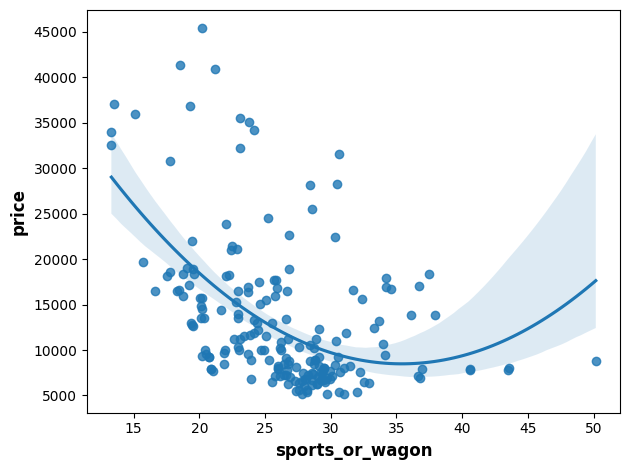

In [12]:
# Create a new column "sports_or_wagon" by dividing "curb_weight" by "horsepower"
df["sports_or_wagon"] = X.curb_weight / X.horsepower

# Create a regression plot to visualize the relationship between "sports_or_wagon" and "price"
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);
